In [55]:
import pandas as pd
import numpy as np

In [56]:
df = pd.read_csv("clean.csv")

In [57]:
df.describe()

,Months_since_Release,A_units,A_values,Avg_Price_unit
count,189.000000,189.000000,189.000000,189.000000
mean,2.000000,340.211640,20700.478544,53.756643
std,0.818665,701.648483,46762.241070,14.279228
min,1.000000,100.000000,2229.526048,22.295260
25%,1.000000,100.000000,4656.894737,43.642000
50%,2.000000,100.000000,6422.285943,52.990000
75%,3.000000,300.000000,15847.986310,64.642667
max,3.000000,7900.000000,502198.008100,79.625471


In [58]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan

# Supposons que vous avez une formule de modèle, par exemple 'A_values ~ A_units + Avg_Price_unit'
# Création du modèle de régression linéaire
model = ols('A_values ~ A_units + Avg_Price_unit', data=df).fit()

# Réalisation du test de Breusch-Pagan sur les résidus du modèle
_, pvalue, _, _ = het_breuschpagan(model.resid, model.model.exog)

print("P-value du test de Breusch-Pagan:", pvalue)


P-value du test de Breusch-Pagan: 1.0786274831210795e-13


In [59]:
from scipy.stats import kstest, expon

# Échantillon de données
data_sample = df['A_units']

# Ajustement des paramètres de la distribution exponentielle aux données
loc, scale = expon.fit(data_sample)

# Réalisation du test de Kolmogorov-Smirnov
ks_statistic, p_value = kstest(data_sample, 'expon', args=(loc, scale))

print("Statistique KS:", ks_statistic, "P-value:", p_value)

Statistique KS: 0.5767195767195767 P-value: 4.0990247182561265e-60


In [60]:
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan

# Transformation logarithmique de A_values
df['log_A_values'] = np.log(df['A_values'])

# Création du modèle de régression linéaire avec la variable transformée
model_log = ols('log_A_values ~ A_units + Avg_Price_unit', data=df).fit()

# Réalisation du test de Breusch-Pagan sur les résidus du modèle transformé
_, pvalue_log, _, _ = het_breuschpagan(model_log.resid, model_log.model.exog)

print("Résumé du modèle avec transformation logarithmique:")
print(model_log.summary())
print("P-value du test de Breusch-Pagan après transformation logarithmique:", pvalue_log)


Résumé du modèle avec transformation logarithmique:
                            OLS Regression Results                            
Dep. Variable:           log_A_values   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     219.0
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           1.28e-49
Time:                        15:24:20   Log-Likelihood:                -159.30
No. Observations:                 189   AIC:                             324.6
Df Residuals:                     186   BIC:                             334.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcul des VIF pour chaque variable explicative
variables = model_log.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

# Affichage des VIF pour chaque variable explicative
vif_dataframe = pd.DataFrame({'Variable': model_log.model.exog_names, 'VIF': vif})
print(vif_dataframe)

         Variable        VIF
0       Intercept  15.442136
1         A_units   1.062211
2  Avg_Price_unit   1.062211


In [62]:
from scipy.stats import spearmanr

# Calcul de la corrélation de Spearman entre A_units et A_values
spearman_corr, spearman_pvalue = spearmanr(df['A_units'], df['A_values'])

print("Corrélation de Spearman entre A_units et A_values:", spearman_corr)
print("P-value de Spearman:", spearman_pvalue)


Corrélation de Spearman entre A_units et A_values: 0.8795210334909249
P-value de Spearman: 3.229497379621004e-62


In [63]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

predictions_dict = {}

for territory in df['Territory_label'].unique():
    territory_data = df[df['Territory_label'] == territory].sort_values('Months_since_Release')
    if len(territory_data) >= 3:
        # Ajout d'une constante pour éviter les valeurs zéro avant de prendre le logarithme
        territory_data['A_units_log'] = np.log(territory_data['A_units'] + 1)  # Ajouter 1 pour éviter log(0)

        # Ajustement du modèle de lissage exponentiel sur les données transformées
        model = ExponentialSmoothing(territory_data['A_units_log'], trend='add', seasonal=None, seasonal_periods=3)
        fit_model = model.fit()

        # Prédiction et retransformation
        predictions_log = fit_model.forecast(9)
        predictions = np.exp(predictions_log) - 1  # Retirer 1 après avoir pris l'exponentielle

        predictions_dict[territory] = predictions
    else:
        print(f"Not enough data to forecast for {territory}")

# Affichage des prédictions
for territory, prediction in predictions_dict.items():
    print(f"Predictions for {territory}:")
    print(prediction)

Predictions for EASTERN EUROPE:
9     105.814794
10     91.459402
11     79.033305
12     68.277215
13     58.966692
14     50.907459
15     43.931347
16     37.892791
17     32.665788
dtype: float64
Predictions for FRANCE:
18    68.211469
19    57.756303
20    48.880507
21    41.345499
22    34.948739
23    29.518280
24    24.908153
25    20.994437
26    17.671932
dtype: float64
Predictions for MIDDLE EAST:
9     81.116549
10    65.812668
11    53.360938
12    43.229810
13    34.986797
14    28.280017
15    22.823164
16    18.383294
17    14.770872
dtype: float64
Predictions for NORDICS:
18    101.563794
19     93.607868
20     86.269086
21     79.499578
22     73.255184
23     67.495171
24     62.181965
25     57.280907
26     52.760027
dtype: float64
Predictions for BENE:
18    82.940739
19    76.336118
20    70.251161
21    64.644980
22    59.479905
23    54.721228
24    50.336972
25    46.297679
26    42.576205
dtype: float64
Predictions for CENTRAL EUROPE:
9     100.0
10    100.0

/opt/homebrew/Caskroom/miniforge/base/envs/Data/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/Data/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniforge/base/envs/Data/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniforge/base/envs/Data/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when

In [64]:
prediction_rows = []
for territory, predictions in predictions_dict.items():
    for month_since_release, units_predicted in enumerate(predictions, start=4):  # starting from month 4
        prediction_rows.append({
            "Months_since_Release": month_since_release,
            "Territory_label": territory,
            "A_units": units_predicted,
            "Avg_Price_unit": np.nan  # Placeholder, can be forecasted or assumed
        })

predictions_df = pd.DataFrame(prediction_rows)

# Combine the original and prediction DataFrames
df_full = pd.concat([df, predictions_df], ignore_index=True)

# Define the function to apply discounts and sales increase
def apply_discount_and_increase_sales(df, month, discount, sales_increase):
    df.loc[df['Months_since_Release'] == month, 'Avg_Price_unit'] *= (1 - discount)
    df.loc[df['Months_since_Release'] == month, 'A_units'] *= (1 + sales_increase)

# Apply discount scenario for month 6 and 8
apply_discount_and_increase_sales(df_full, 6, 0.20, 0.05)  # 20% discount, 5% increase in sales
apply_discount_and_increase_sales(df_full, 8, 0.30, 0.0085)  # 30% discount, 0.85% increase in sales

# Display adjusted DataFrame
print(df_full)

     Months_since_Release   Format     A_units     A_values Platform_Label   
0                       3  DIGITAL  300.000000  11217.48925            PS4  \
1                       3  DIGITAL  300.000000  13831.88372            PS4   
2                       3  DIGITAL  300.000000  12625.53589            PS4   
3                       3  DIGITAL  300.000000  14551.99476            PS4   
4                       3  DIGITAL  100.000000   4491.29932             PC   
..                    ...      ...         ...          ...            ...   
319                     8      NaN   35.587358          NaN            NaN   
320                     9      NaN   30.113884          NaN            NaN   
321                    10      NaN   25.677948          NaN            NaN   
322                    11      NaN   21.874448          NaN            NaN   
323                    12      NaN   18.613216          NaN            NaN   

              Territory_label  Avg_Price_unit  log_A_values  
0

In [65]:
import seaborn as sns

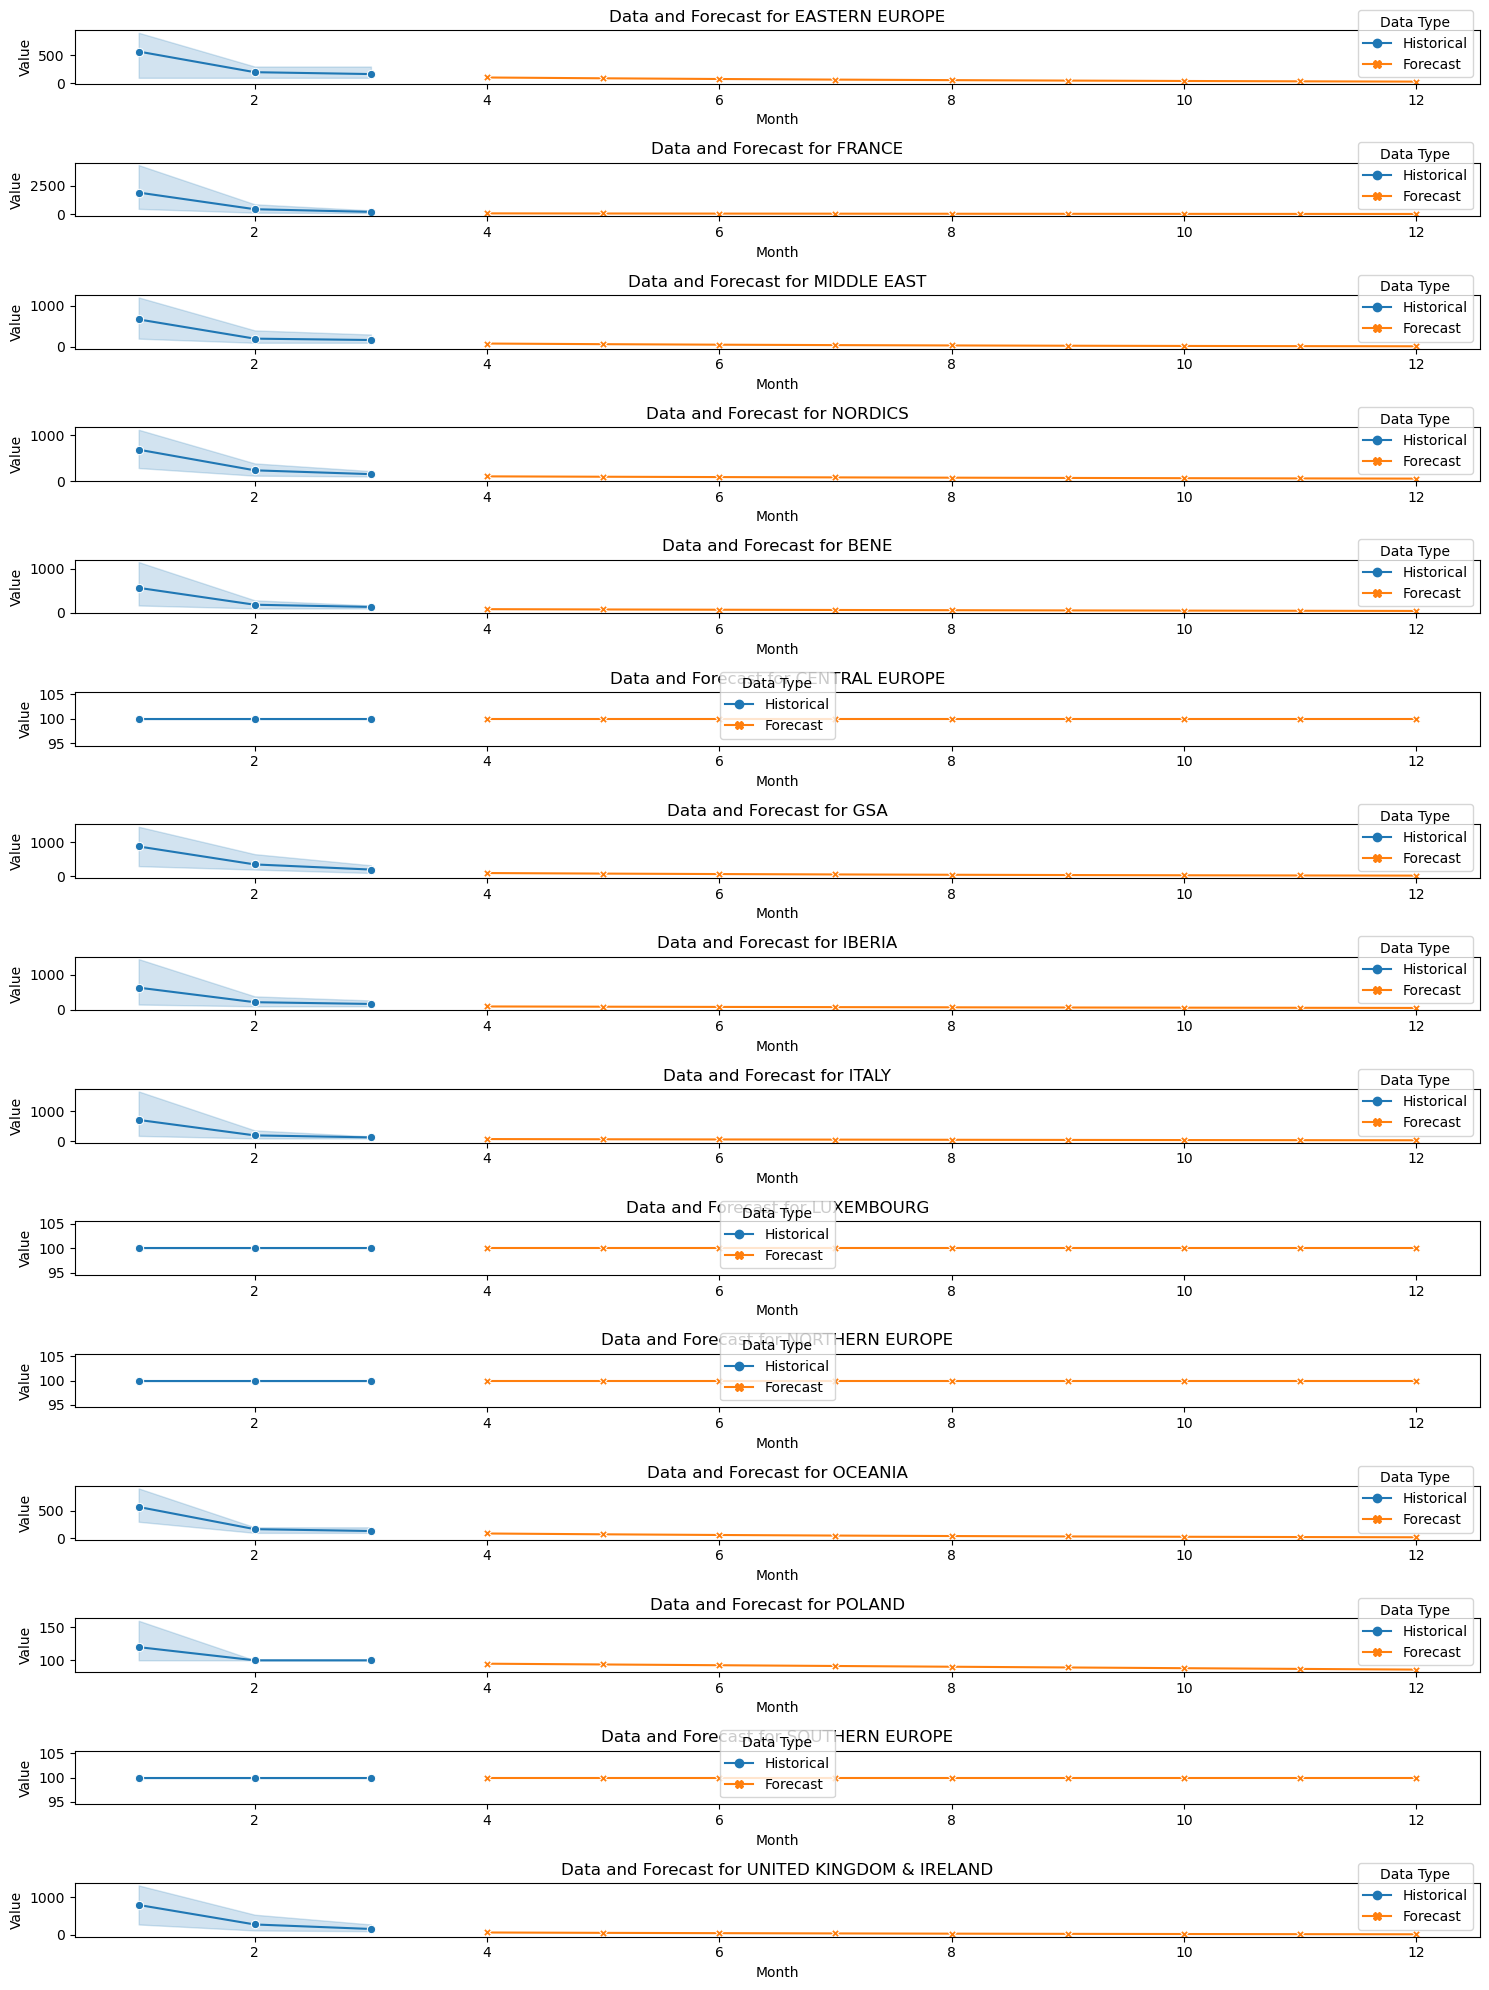

In [66]:
plt.figure(figsize=(15, 20))

for i, territory in enumerate(predictions_dict.keys(), 1):
    plt.subplot(len(predictions_dict), 1, i)
    # Extraire les données historiques pour le territoire actuel
    historical_data = df[df['Territory_label'] == territory]
    # Préparer les prévisions pour le graphique
    predictions = predictions_dict[territory]
    # Créer un DataFrame pour les données historiques
    historical_df = pd.DataFrame({
        'Value': historical_data['A_units'],
        'Month': historical_data['Months_since_Release'],
        'Type': 'Historical'
    })
    # Les mois de prévision commencent après le dernier mois disponible dans les données historiques
    last_month = historical_data['Months_since_Release'].max()
    forecast_months = range(last_month + 1, last_month + 1 + len(predictions))
    # Créer un DataFrame pour les prédictions
    forecast_df = pd.DataFrame({
        'Value': predictions.values,
        'Month': forecast_months,
        'Type': 'Forecast'
    })
    # Concaténer les données historiques et les prévisions
    full_df = pd.concat([historical_df, forecast_df])
    
    # Tracer les données en utilisant seaborn pour un meilleur style
    sns.lineplot(data=full_df, x='Month', y='Value', hue='Type', style='Type', markers=True, dashes=False, palette='tab10')
    plt.title(f'Data and Forecast for {territory}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.legend(title='Data Type')

plt.tight_layout()
plt.show()


In [67]:
df_full

,Months_since_Release,Format,A_units,A_values,Platform_Label,Territory_label,Avg_Price_unit,log_A_values
0,3,DIGITAL,300.000000,11217.48925,PS4,EASTERN EUROPE,37.391631,9.325229
1,3,DIGITAL,300.000000,13831.88372,PS4,FRANCE,46.106279,9.534732
2,3,DIGITAL,300.000000,12625.53589,PS4,MIDDLE EAST,42.085120,9.443477
3,3,DIGITAL,300.000000,14551.99476,PS4,NORDICS,48.506649,9.585483
4,3,DIGITAL,100.000000,4491.29932,PC,BENE,44.912993,8.409897
...,...,...,...,...,...,...,...,...
319,8,NaN,35.587358,NaN,NaN,UNITED KINGDOM & IRELAND,NaN,NaN
320,9,NaN,30.113884,NaN,NaN,UNITED KINGDOM & IRELAND,NaN,NaN
321,10,NaN,25.677948,NaN,NaN,UNITED KINGDOM & IRELAND,NaN,NaN
322,11,NaN,21.874448,NaN,NaN,UNITED KINGDOM & IRELAND,NaN,NaN


In [69]:
unique_combinations = df[['Platform_Label', 'Format']].drop_duplicates()

# Calculate median prices per combination and keep all necessary columns
median_prices = df.groupby(['Platform_Label', 'Format']).agg({
    'Avg_Price_unit': 'median',
    'A_units': 'mean'  # Assuming you want to use the mean A_units for simplicity
}).reset_index()

# Function to apply discounts and adjust units
def apply_discount(row, discount, increase):
    new_price = row['Avg_Price_unit'] * (1 - discount)
    new_units = row['A_units'] * (1 + increase)
    new_values = new_units * new_price
    return pd.Series({
        'Platform_Label': row['Platform_Label'],
        'Format': row['Format'],
        'Avg_Price_unit': new_price,
        'A_units': new_units,
        'A_values': new_values,
        'log_A_values': np.log(new_values)
    })

# Applying discounts for months 6 and 8
month_6 = median_prices.apply(lambda row: apply_discount(row, 0.20, 0.05), axis=1)
month_8 = median_prices.apply(lambda row: apply_discount(row, 0.30, 0.0085), axis=1)

# Simulated forecast data (replace with your forecast function)
month_6['forecast'] = month_6['A_values'] * 1.1
month_8['forecast'] = month_8['A_values'] * 1.2

# Tagging scenarios
month_6['scenario'] = '20% discount'
month_8['scenario'] = '30% discount'

# Combining all data
final_df = pd.concat([df, month_6, month_8])

# Export to CSV
final_df.to_csv('final_forecast_data.csv', index=False)

print("Data with scenarios and forecasts has been saved to 'final_forecast_data.csv'.")


Data with scenarios and forecasts has been saved to 'final_forecast_data.csv'.
